In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from random import random
from tqdm import tqdm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

df = pd.read_csv('train.csv').reset_index(drop=True)
X = [] # features list
df.tail(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


### pre-process:

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### EDA + Feature engineering:

In [63]:
def graph_boxplot(data:pd.DataFrame(),x:str,y:str):
    sns.set_theme(style="ticks", palette="pastel")
    data = data[[x,y]].dropna().reset_index()
    sum = data.groupby(x)[y].agg(['mean','median']).to_dict()
    plt.figure(figsize=(len(sum['mean'].keys()), 6))
    sns.set_style(rc = {'axes.facecolor': '#F2F3F4','axes.edgecolor': '#273746'})
    
    #sns.lineplot(x=sum['mean'].keys(),y=sum['mean'].values(),color='#58D68D')
    sns.boxplot(data=data,x=x,y=y,fliersize=0,width=0.8)
    sns.stripplot(data=data,x=x,y=y,size=3,jitter=0.3,color='white',edgecolor='#212F3D',linewidth=1)
    sns.stripplot(x=sum['median'].keys(),y=sum['median'].values(),color='#FA8072',edgecolor='#212F3D',legend=False,size=6,linewidth=1,marker='D')
    sns.stripplot(x=sum['mean'].keys(),y=sum['mean'].values(),color='#58D68D',edgecolor='#212F3D',legend=False,size=6,linewidth=1,marker='o')
    
    return plt.show()

In [72]:
def graph_scatter(data:pd.DataFrame(),x:str,y:str):
    sns.set_theme(style="ticks", palette="pastel")
    data = data[[x,y]].dropna().reset_index()
    plt.figure(figsize=(10, 6))
    sns.set_style(rc = {'axes.facecolor': '#F2F3F4','axes.edgecolor': '#273746'})

    sns.scatterplot(data=data,x=x,y=y)

    return plt.show()

Original values dist:{2006: 67, 2005: 64, 2004: 54, 2007: 49, 2003: 45, 1976: 33, 1977: 32, 1920: 30, 1959: 26, 1998: 25, 1999: 25, 1965: 24, 2000: 24, 1970: 24, 1954: 24, 1958: 24, 2008: 23, 2002: 23, 1972: 23, 1971: 22, 1968: 22, 1950: 20, 1957: 20, 2001: 20, 1994: 19, 1962: 19, 1940: 18, 1966: 18, 2009: 18, 1995: 18, 1910: 17, 1993: 17, 1960: 17, 1963: 16, 1978: 16, 1925: 16, 1955: 16, 1967: 16, 1996: 15, 1941: 15, 1964: 15, 1961: 14, 1948: 14, 1956: 14, 1969: 14, 1997: 14, 1992: 13, 1953: 12, 1990: 12, 1949: 12, 1973: 11, 1988: 11, 1900: 10, 1974: 10, 1915: 10, 1980: 10, 1984: 9, 1926: 9, 1936: 9, 1979: 9, 1930: 9, 1922: 8, 1975: 8, 1939: 8, 1916: 8, 1928: 7, 1914: 7, 1923: 7, 1924: 7, 1918: 7, 1946: 7, 1935: 6, 1951: 6, 1921: 6, 1945: 6, 1982: 6, 1931: 6, 1986: 5, 1937: 5, 1981: 5, 1991: 5, 1947: 5, 1952: 5, 1985: 5, 1929: 4, 1938: 4, 1983: 4, 1932: 4, 1880: 4, 1919: 3, 1989: 3, 1912: 3, 1927: 3, 1987: 3, 1934: 3, 1942: 2, 1890: 2, 1885: 2, 1908: 2, 1892: 2, 1913: 1, 1893: 1, 1906

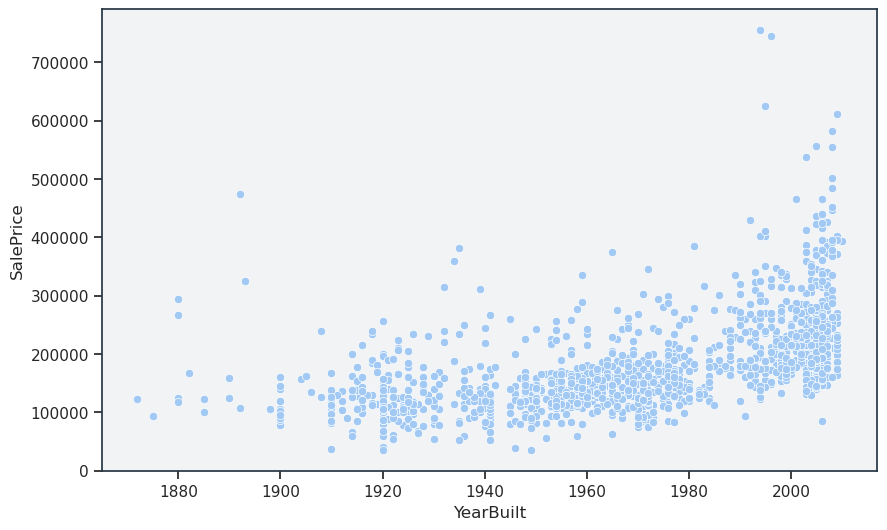

In [73]:
COLUMN = 'YearBuilt'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_scatter(data=df,x=COLUMN,y='SalePrice')

Original values dist:{5: 821, 6: 252, 7: 205, 8: 72, 4: 57, 3: 25, 9: 22, 2: 5, 1: 1}


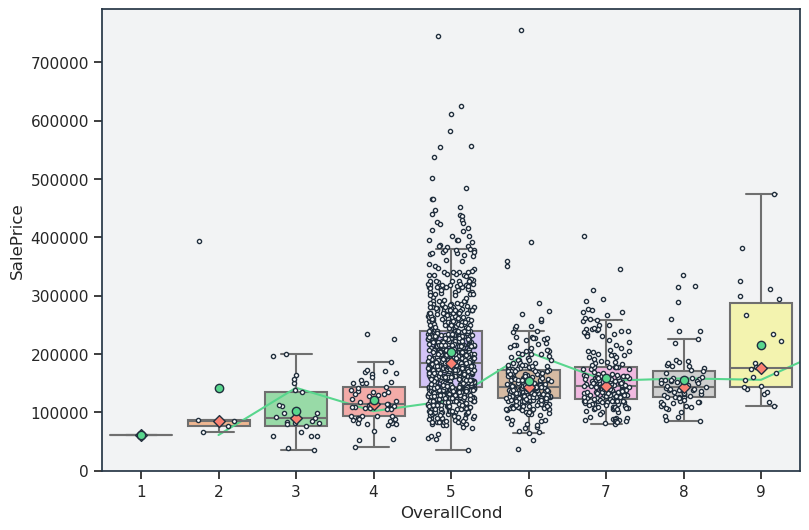

In [60]:
COLUMN = 'OverallCond'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

{1: 50150.0, 2: 51770.333333333336, 3: 87473.75, 4: 108420.6551724138, 5: 133523.34760705288, 6: 161603.0347593583, 7: 207716.42319749217, 8: 274735.53571428574, 9: 367513.0232558139, 10: 438588.3888888889}


<AxesSubplot:>

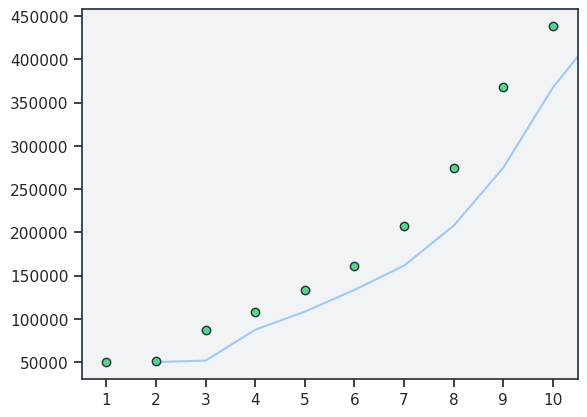

In [73]:
data = df
x = 'OverallQual'
y = 'SalePrice'
sum = data.groupby(x)[y].mean().to_dict()
print(sum)
sns.lineplot(x=sum.keys(),y=sum.values(),)
#sns.boxplot(data=data,x=x,y=y,fliersize=0,width=0.8)
sns.stripplot(x=sum.keys(),y=sum.values(),color='#58D68D',edgecolor='#212F3D',legend=False,size=6,linewidth=1)

Original values dist:{5: 397, 6: 374, 7: 319, 8: 168, 4: 116, 9: 43, 3: 20, 10: 18, 2: 3, 1: 2}


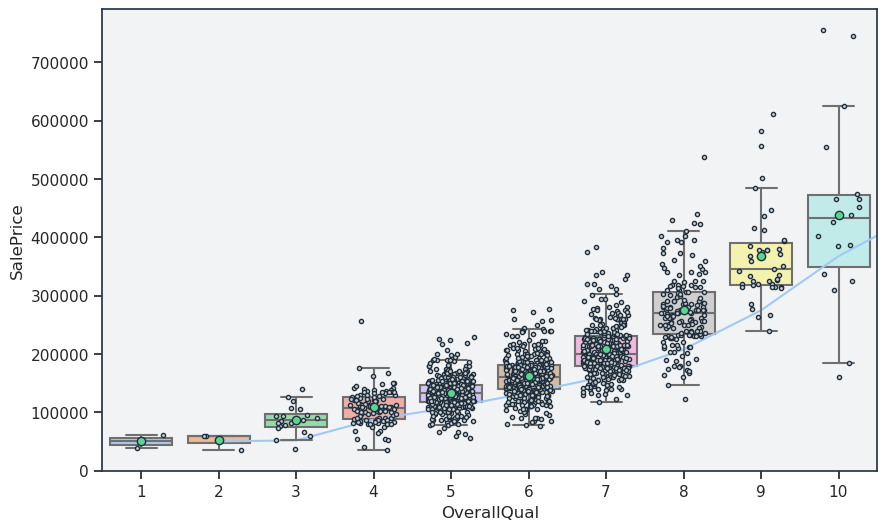

In [68]:
COLUMN = 'OverallQual'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

#df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
#print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
#df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
#print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
#X.append(COLUMN)
#print(f'Current Features:{X}')

Original values dist:{'1Story': 726, '2Story': 445, '1.5Fin': 154, 'SLvl': 65, 'SFoyer': 37, '1.5Unf': 14, '2.5Unf': 11, '2.5Fin': 8}


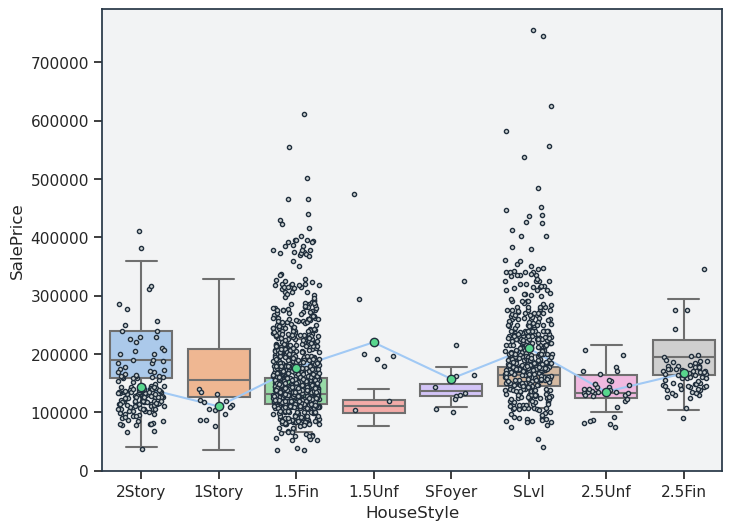

Featured values dist:{0.497: 726, 0.305: 445, 0.105: 154, 0.045: 65, 0.025: 37, 0.01: 14, 0.008: 11, 0.005: 8}
Values after scaling:{0.868: 726, -0.297: 445, -1.511: 154, -1.875: 65, -1.996: 37, -2.087: 14, -2.1: 11, -2.118: 8}
Current Features:['HouseStyle']


In [74]:
COLUMN = 'HouseStyle'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

Original values dist:{'1Fam': 1220, 'TwnhsE': 114, 'Duplex': 52, 'Twnhs': 43, '2fmCon': 31}


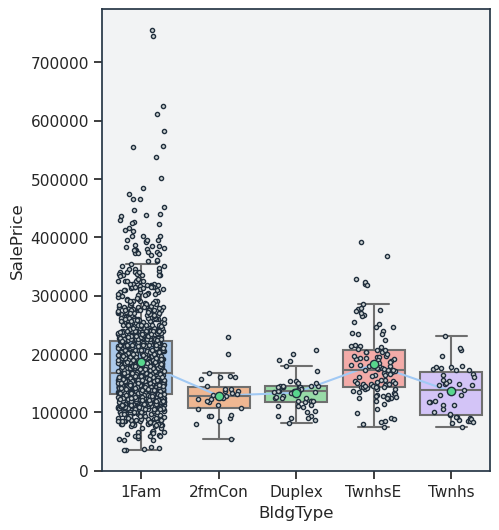

Featured values dist:{0.836: 1220, 0.078: 114, 0.036: 52, 0.029: 43, 0.021: 31}
Values after scaling:{0.443: 1220, -2.166: 114, -2.31: 52, -2.334: 43, -2.362: 31}
Current Features:['HouseStyle', 'BldgType']


In [44]:
COLUMN = 'BldgType'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

Original values dist:{'Norm': 1445, 'Feedr': 6, 'Artery': 2, 'RRNn': 2, 'PosN': 2, 'PosA': 1, 'RRAn': 1, 'RRAe': 1}


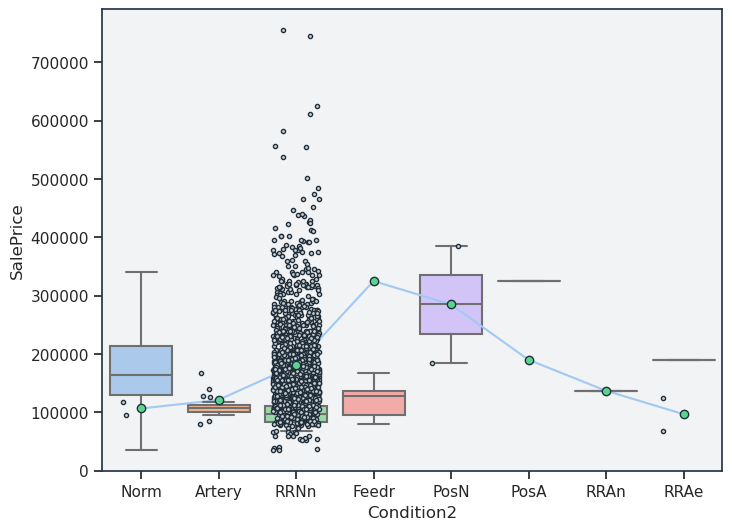

data is too biased > can drop this column
Current Features:['HouseStyle']


In [75]:
COLUMN = 'Condition2'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

print('data is too biased > can drop this column')
print(f'Current Features:{X}')

Original values dist:{'Norm': 1260, 'Feedr': 81, 'Artery': 48, 'RRAn': 26, 'PosN': 19, 'RRAe': 11, 'PosA': 8, 'RRNn': 5, 'RRNe': 2}


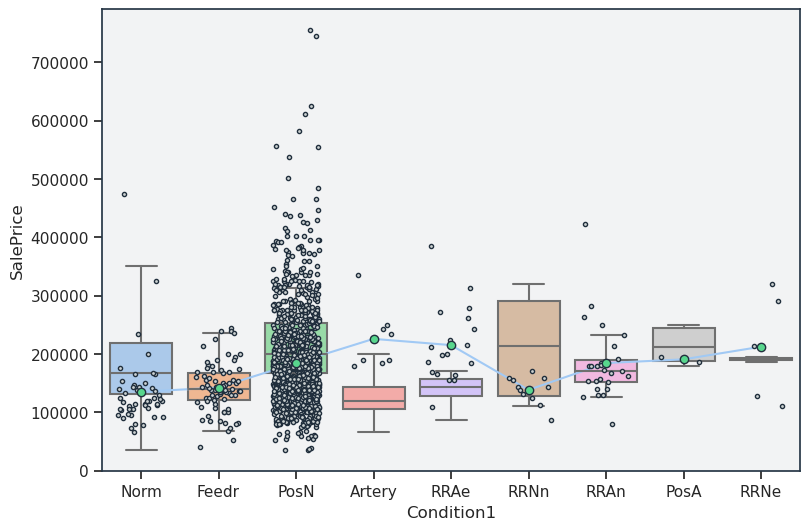

Featured values dist:{0.863: 1260, 0.055: 81, 0.033: 48, 0.018: 26, 0.013: 19, 0.008: 11, 0.005: 8, 0.003: 5, 0.001: 2}
Values after scaling:{0.398: 1260, -2.436: 81, -2.514: 48, -2.566: 26, -2.584: 19, -2.601: 11, -2.612: 8, -2.619: 5, -2.626: 2}
Current Features:['HouseStyle', 'Condition1']


In [76]:
COLUMN = 'Condition1'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

Original values dist:{'NAmes': 225, 'CollgCr': 150, 'OldTown': 113, 'Edwards': 100, 'Somerst': 86, 'Gilbert': 79, 'NridgHt': 77, 'Sawyer': 74, 'NWAmes': 73, 'SawyerW': 59, 'BrkSide': 58, 'Crawfor': 51, 'Mitchel': 49, 'NoRidge': 41, 'Timber': 38, 'IDOTRR': 37, 'ClearCr': 28, 'StoneBr': 25, 'SWISU': 25, 'MeadowV': 17, 'Blmngtn': 17, 'BrDale': 16, 'Veenker': 11, 'NPkVill': 9, 'Blueste': 2}


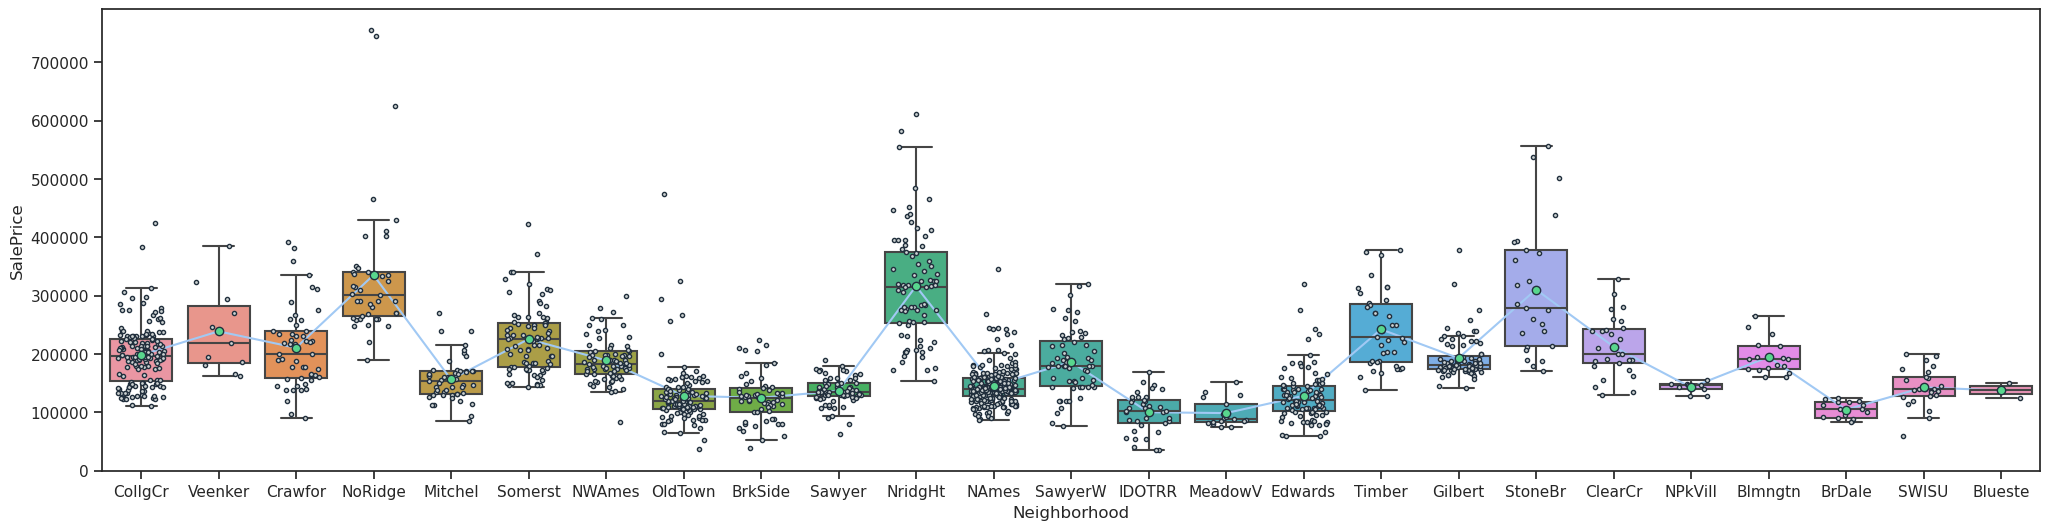

Featured values dist:{0.154: 225, 0.103: 150, 0.04: 117, 0.077: 113, 0.068: 100, 0.059: 86, 0.054: 79, 0.053: 77, 0.051: 74, 0.05: 73, 0.035: 51, 0.017: 50, 0.034: 49, 0.028: 41, 0.026: 38, 0.025: 37, 0.012: 34, 0.019: 28, 0.011: 16, 0.008: 11, 0.006: 9, 0.001: 2}
Values after scaling:{1.961: 225, 0.794: 150, -0.648: 117, 0.199: 113, -0.007: 100, -0.213: 86, -0.328: 79, -0.351: 77, -0.396: 74, -0.419: 73, -0.763: 51, -1.175: 50, -0.785: 49, -0.923: 41, -0.969: 38, -0.991: 37, -1.289: 34, -1.129: 28, -1.312: 16, -1.38: 11, -1.426: 9, -1.541: 2}
Current Features:['Condition1', 'Neighborhood']


In [169]:
COLUMN = 'Neighborhood'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

Original values dist:{'Gtl': 1382, 'Mod': 65, 'Sev': 13}


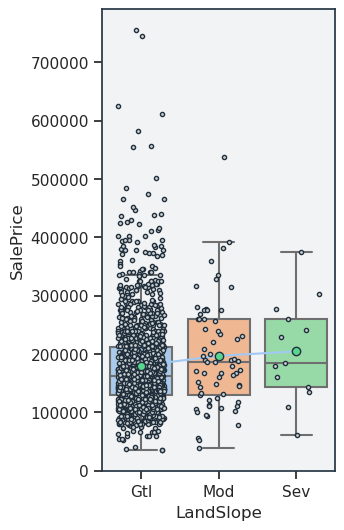

data is too biased > can drop this column
Current Features:['HouseStyle', 'Condition1']


In [77]:
COLUMN = 'LandSlope'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

print('data is too biased > can drop this column')
print(f'Current Features:{X}')

Original values dist:{'Inside': 1052, 'Corner': 263, 'CulDSac': 94, 'FR2': 47, 'FR3': 4}


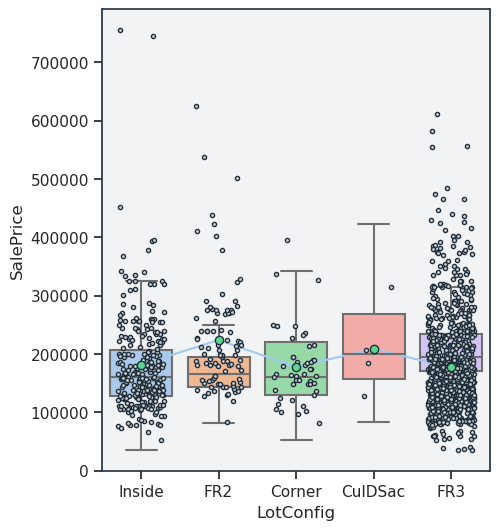

Featured values dist:{0.721: 1052, 0.18: 263, 0.064: 94, 0.032: 47, 0.003: 4}
Values after scaling:{0.618: 1052, -1.421: 263, -1.859: 94, -1.979: 47, -2.088: 4}
Current Features:['HouseStyle', 'Condition1', 'LotConfig']


In [78]:
COLUMN = 'LotConfig'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

Original values dist:{'AllPub': 1459, 'NoSeWa': 1}


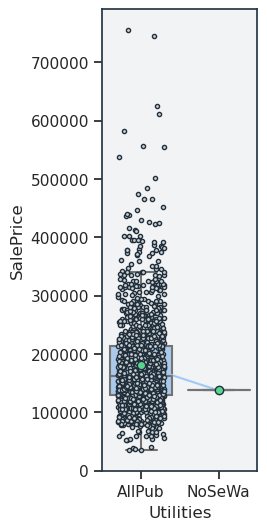

data is too biased > can drop this column
Current Features:['HouseStyle', 'Condition1', 'LotConfig']


In [79]:
COLUMN = 'Utilities'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')
print('data is too biased > can drop this column')
df = df.drop(columns=[COLUMN], axis=1)
print(f'Current Features:{X}')

Original values dist:{'Lvl': 1311, 'Bnk': 63, 'HLS': 50, 'Low': 36}


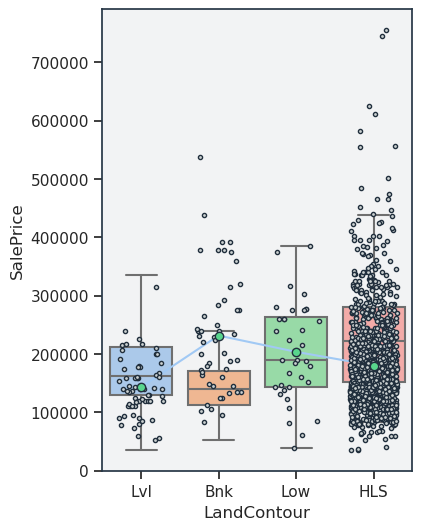

Featured values dist:{0.898: 1311, 0.043: 63, 0.034: 50, 0.025: 36}
Values after scaling:{0.337: 1311, -2.937: 63, -2.971: 50, -3.006: 36}
Current Features:['HouseStyle', 'Condition1', 'LotConfig', 'LandContour']


In [80]:
COLUMN = 'LandContour'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

Original values dist:{'Reg': 925, 'IR1': 484, 'IR2': 41, 'IR3': 10}


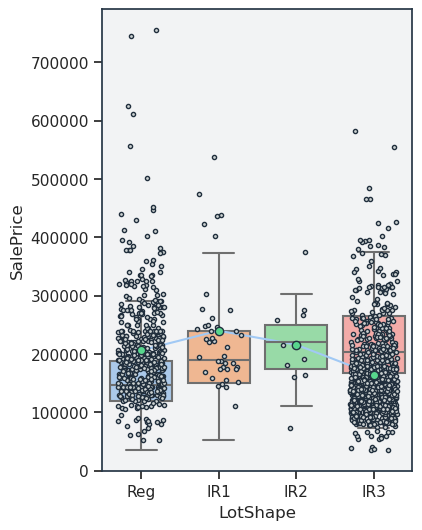

Featured values dist:{0.634: 925, 0.332: 484, 0.028: 41, 0.007: 10}
Values after scaling:{0.719: 925, -1.069: 484, -2.87: 41, -2.994: 10}
Current Features:['HouseStyle', 'Condition1', 'LotConfig', 'LandContour', 'LotShape']


In [81]:
# MSZoning
COLUMN = 'LotShape'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

Original values dist:{'RL': 1151, 'RM': 218, 'FV': 65, 'RH': 16, 'C (all)': 10}


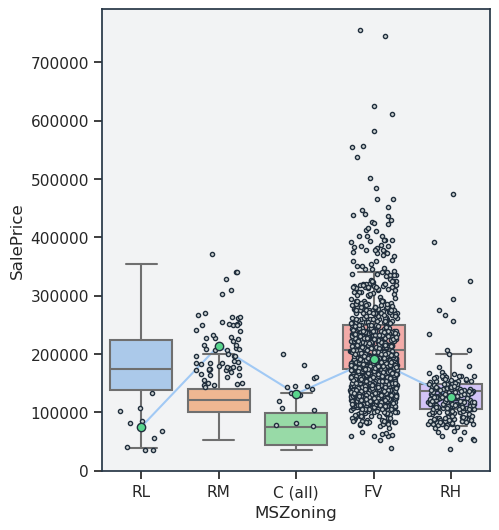

Featured values dist:{0.788: 1151, 0.149: 218, 0.045: 65, 0.011: 16, 0.007: 10}
Values after scaling:{0.516: 1151, -1.8: 218, -2.177: 65, -2.3: 16, -2.315: 10}
Current Features:['HouseStyle', 'Condition1', 'LotConfig', 'LandContour', 'LotShape', 'MSZoning']


In [82]:
# MSZoning
COLUMN = 'MSZoning'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

Original values dist:{'Pave': 1454, 'Grvl': 6}


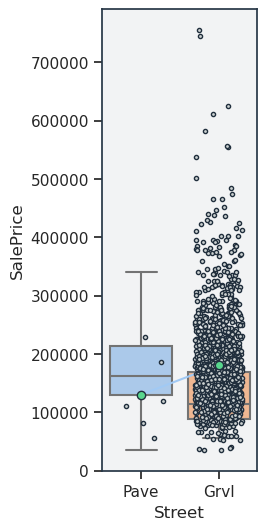

data is too biased > can drop this column
Current Features:['HouseStyle', 'Condition1', 'LotConfig', 'LandContour', 'LotShape', 'MSZoning']


In [83]:
# Street
COLUMN = 'Street'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

print('data is too biased > can drop this column')
print(f'Current Features:{X}')

Original values dist:{'Grvl': 50, 'Pave': 41}


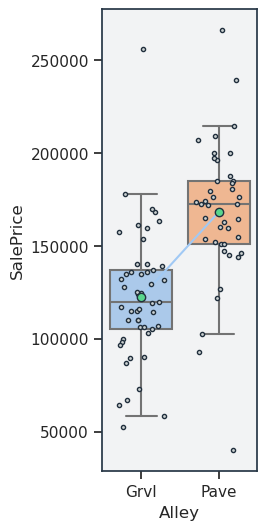

Featured values dist:{0.0: 1369, 0.034: 50, 0.028: 41}
Values after scaling:{-0.256: 1369, 4.214: 50, 3.425: 41}
Current Features:['HouseStyle', 'Condition1', 'LotConfig', 'LandContour', 'LotShape', 'MSZoning', 'Alley']


In [84]:
COLUMN = 'Alley'
print(f"Original values dist:{df[COLUMN].value_counts().to_dict()}")
graph_boxplot(data=df,x=COLUMN,y='SalePrice')

print(f"will need to fill these values somehow")
df[COLUMN] = [round(len(df[df[COLUMN]==val])/len(df),3) for val in df[COLUMN]]
print(f"Featured values dist:{df[COLUMN].value_counts().to_dict()}")
df[COLUMN] = np.round((df[COLUMN] - df[COLUMN].mean())/df[COLUMN].std(),3)
print(f"Values after scaling:{df[COLUMN].value_counts().to_dict()}")
X.append(COLUMN)
print(f'Current Features:{X}')

### Model regression:

In [85]:
# model parameters
y = 'SalePrice'
X = X
TEST_AMOUNT = 0.3
EXCLUDE_OUTLIERS = True
print(f'X:{X}\ny:{y}\nTest set:{TEST_AMOUNT}\nTrain set:{1-TEST_AMOUNT}\nExclude Outliers:{EXCLUDE_OUTLIERS}')

# test train distribution
df = df[X + [y]].dropna().reset_index(drop=True)
df['set'] = None
df['set'] = ['test' if random() < TEST_AMOUNT else 'train' for item in df.set]
print(f"\nData set distribution:{df.set.value_counts().to_dict()}")

X:['HouseStyle', 'Condition1', 'LotConfig', 'LandContour', 'LotShape', 'MSZoning', 'Alley']
y:SalePrice
Test set:0.3
Train set:0.7
Exclude Outliers:True

Data set distribution:{'train': 1001, 'test': 459}


In [86]:
# create regression model
X_train = df.loc[df.set=='train',X] 
X_test = df.loc[df.set=='test',X]  
y_train = np.ravel(np.array(df[df['set'] == 'train'][y]).reshape(-1,1))
y_test = df.loc[df.set=='test',y] 

voting_reg = VotingRegressor(estimators=[('dt',DecisionTreeRegressor()),
                                         ('rf',RandomForestRegressor()),
                                         ('lr',LinearRegression()),
                                         ('knn',KNeighborsRegressor()),
                                         ('adaboost',AdaBoostRegressor()),
                                         ('gbr',GradientBoostingRegressor()),
                                         ('xgb',XGBRegressor()),
                                         ('svr',SVR()),
                                         ('ridge',Ridge()), 
                                         ('lasso',Lasso())
                                          ]
                                    )

df.tail(3)

,HouseStyle,Condition1,LotConfig,LandContour,LotShape,MSZoning,Alley,SalePrice,set
1457,-0.297,0.398,0.618,0.337,0.719,0.516,-0.256,266500,train
1458,0.868,0.398,0.618,0.337,0.719,0.516,-0.256,142125,test
1459,0.868,0.398,0.618,0.337,0.719,0.516,-0.256,147500,train


In [87]:
# Train & predict
test_rmse = []
train_rmse = []
for itr in tqdm(range(0,10)):
    voting_reg.fit(X_train, y_train)
    df['price_predict'] = voting_reg.predict(df[X])

    # Evaluate the model
    y_train_pred = df.loc[df.set=='train','price_predict']
    y_train = df.loc[df.set=='train',y]
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))

    y_pred = df.loc[df.set=='test','price_predict']
    y_test = df.loc[df.set=='test',y]
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print(f"Test_RMSE = {round(np.mean(test_rmse),3)} +- {round(np.std(test_rmse),3)}\nTrain_RMSE = {round(np.mean(train_rmse),3)} +- {round(np.std(train_rmse),3)}\nMean SalePrice = {round(df['SalePrice'].mean(),3)} +- {round(df['SalePrice'].std(),3)}")

100%|██████████| 10/10 [01:18<00:00,  7.85s/it]

Test_RMSE = 69300.02 +- 121.961
Train_RMSE = 66316.242 +- 66.232
Mean SalePrice = 180921.196 +- 79442.503
